In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%pip install datasets evaluate rouge_score faiss-cpu

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=d025f32ccaed4b1ac71fd68800a341df515ba6deb620e543ea22de107062de27
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is inco

## **Import libraries**

In [3]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

2025-04-29 04:18:17.686762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745900298.088026      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745900298.203269      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Load dataset**

In [4]:
ds = load_dataset("316usman/research_clinical_visit_note_summarization_corpus_mts")

README.md:   0%|          | 0.00/525 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/561k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/43.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/182k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1201 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 1201
    })
    validation: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 100
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 400
    })
})

In [6]:
ds.shape

{'train': (1201, 2), 'validation': (100, 2), 'test': (400, 2)}

## **Load models and tokenizers**

In [7]:
# load T5 model
t5_name ='google/flan-t5-base'
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_name)

# T5 tokenizer
# parameter use_fast switches on fast tokenizer
t5_tokenizer = AutoTokenizer.from_pretrained(t5_name, use_fast=True)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [8]:
# load BART model
bart_name = 'facebook/bart-large-cnn'
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_name)

# BART tokenizer
bart_tokenizer = AutoTokenizer.from_pretrained(bart_name, use_fast=True)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## **EDA**

In [9]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

In [10]:
# token length computation function
def compute_token_lengths(example):
    dialogue = example['prompt']
    summary = example['completion']
    
    # T5 tokenizer
    dialogue_len_t5 = len(t5_tokenizer(dialogue, truncation=True, padding=False)['input_ids'])
    summary_len_t5 = len(t5_tokenizer(summary, truncation=True, padding=False)['input_ids'])
    
    # BART tokenizer
    dialogue_len_bart = len(bart_tokenizer(dialogue, truncation=True, padding=False)['input_ids'])
    summary_len_bart = len(bart_tokenizer(summary, truncation=True, padding=False)['input_ids'])
    
    return {
        'dialogue_len_t5': dialogue_len_t5,
        'summary_len_t5': summary_len_t5,
        'dialogue_len_bart': dialogue_len_bart,
        'summary_len_bart': summary_len_bart
    }

In [11]:
def process_split(split_name):
    split_dataset = ds[split_name]
    lengths_dataset = split_dataset.map(compute_token_lengths)
    
    dialogue_lengths_t5 = lengths_dataset['dialogue_len_t5']
    summary_lengths_t5 = lengths_dataset['summary_len_t5']
    dialogue_lengths_bart = lengths_dataset['dialogue_len_bart']
    summary_lengths_bart = lengths_dataset['summary_len_bart']
    
    print(f"\n--- {split_name.upper()} ---")
    print(f"T5 - Avg dialogue length: {np.mean(dialogue_lengths_t5):.2f}, Max: {np.max(dialogue_lengths_t5)}")
    print(f"T5 - Avg summary length: {np.mean(summary_lengths_t5):.2f}, Max: {np.max(summary_lengths_t5)}")
    print(f"BART - Avg dialogue length: {np.mean(dialogue_lengths_bart):.2f}, Max: {np.max(dialogue_lengths_bart)}")
    print(f"BART - Avg summary length: {np.mean(summary_lengths_bart):.2f}, Max: {np.max(summary_lengths_bart)}")
    
    return dialogue_lengths_t5, summary_lengths_t5, dialogue_lengths_bart, summary_lengths_bart

In [12]:
# process each split
splits = ['train', 'validation', 'test']
all_lengths = {}

for split in splits:
    all_lengths[split] = process_split(split)

Map:   0%|          | 0/1201 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



--- TRAIN ---
T5 - Avg dialogue length: 144.24, Max: 512
T5 - Avg summary length: 58.52, Max: 512
BART - Avg dialogue length: 162.50, Max: 2326
BART - Avg summary length: 57.52, Max: 1452


Map:   0%|          | 0/100 [00:00<?, ? examples/s]


--- VALIDATION ---
T5 - Avg dialogue length: 125.72, Max: 512
T5 - Avg summary length: 53.90, Max: 406
BART - Avg dialogue length: 137.71, Max: 831
BART - Avg summary length: 51.48, Max: 380


Map:   0%|          | 0/400 [00:00<?, ? examples/s]


--- TEST ---
T5 - Avg dialogue length: 142.08, Max: 512
T5 - Avg summary length: 57.28, Max: 512
BART - Avg dialogue length: 156.87, Max: 1525
BART - Avg summary length: 55.82, Max: 682


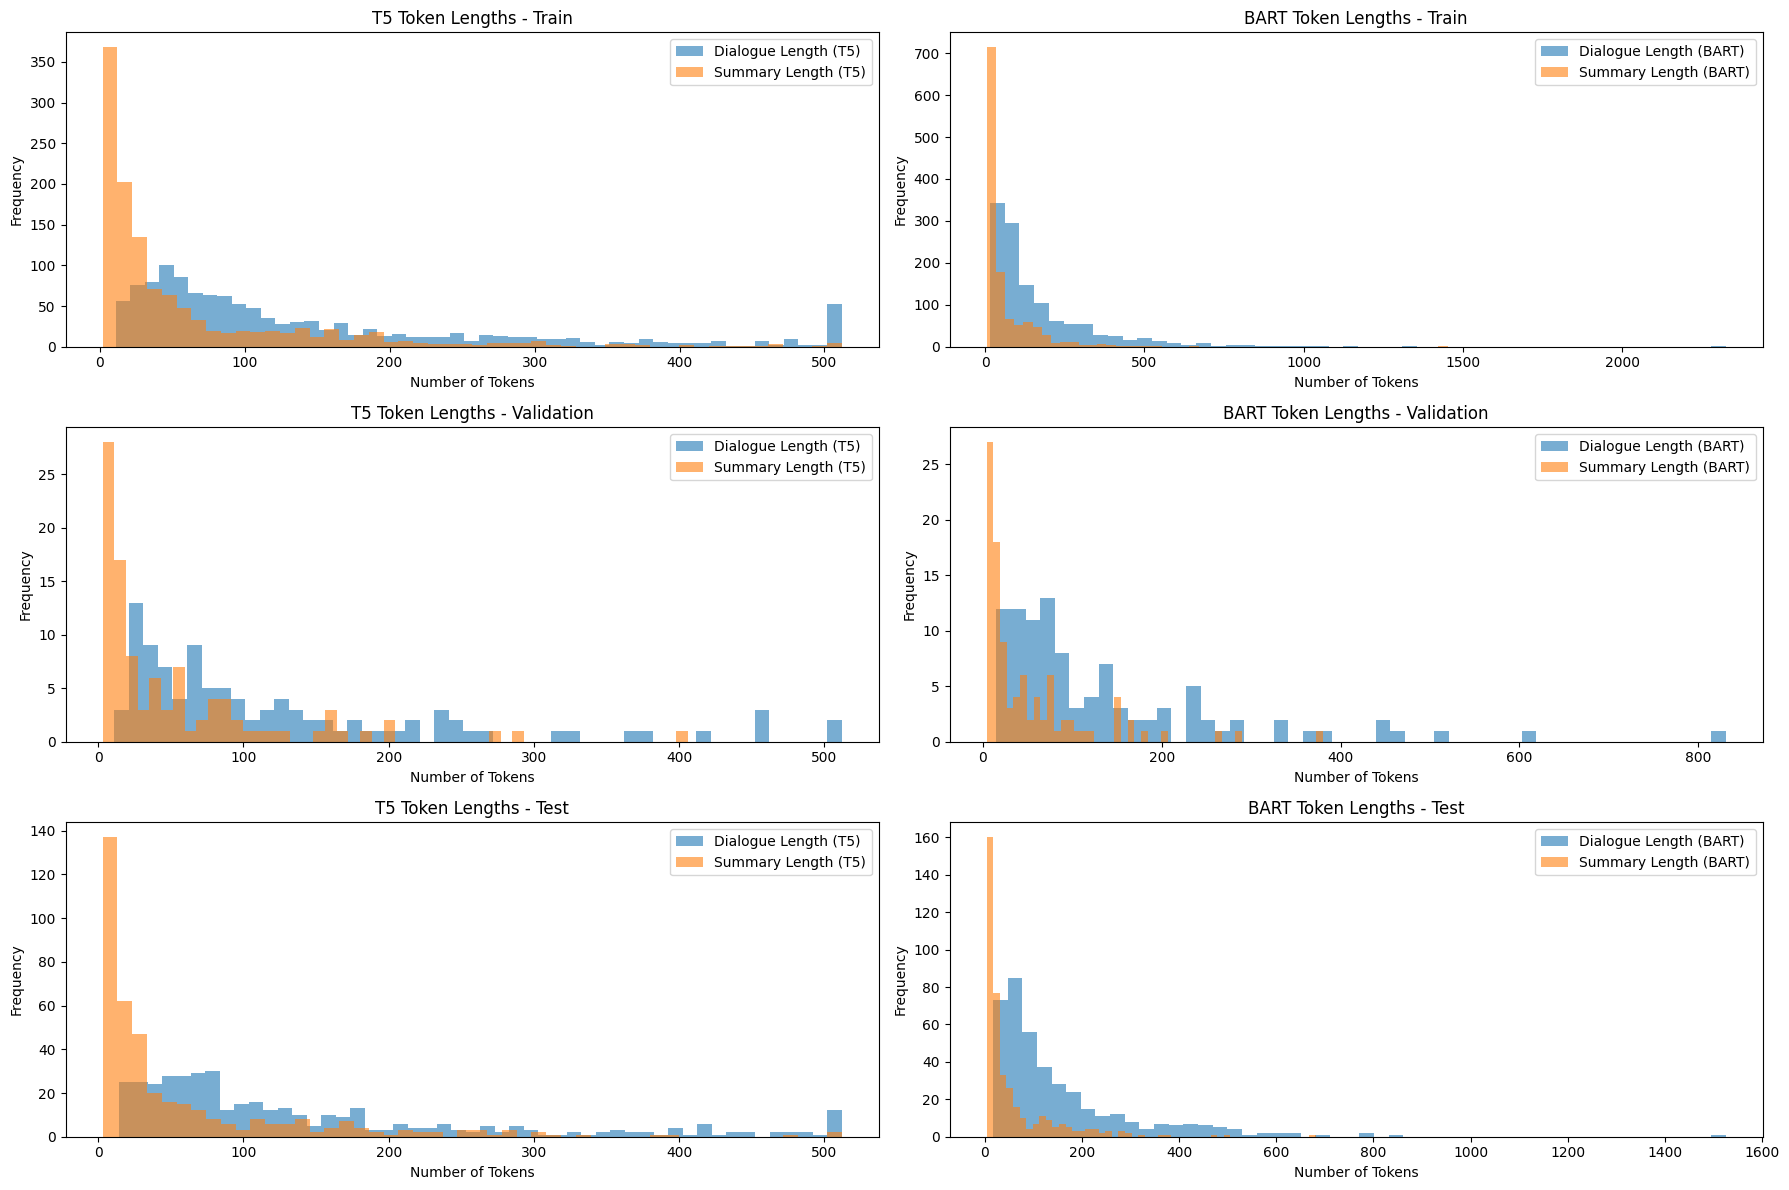

In [13]:
plt.figure(figsize=(18, 12))

for idx, split in enumerate(splits):
    dialogue_lengths_t5, summary_lengths_t5, dialogue_lengths_bart, summary_lengths_bart = all_lengths[split]
    
    plt.subplot(3, 2, idx*2+1)
    plt.hist(dialogue_lengths_t5, bins=50, alpha=0.6, label='Dialogue Length (T5)')
    plt.hist(summary_lengths_t5, bins=50, alpha=0.6, label='Summary Length (T5)')
    plt.title(f'T5 Token Lengths - {split.capitalize()}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(3, 2, idx*2+2)
    plt.hist(dialogue_lengths_bart, bins=50, alpha=0.6, label='Dialogue Length (BART)')
    plt.hist(summary_lengths_bart, bins=50, alpha=0.6, label='Summary Length (BART)')
    plt.title(f'BART Token Lengths - {split.capitalize()}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# convert HF dataset to df
train_df = pd.DataFrame(ds['train'])
val_df = pd.DataFrame(ds['validation'])
test_df = pd.DataFrame(ds['test'])

In [15]:
df = pd.concat([train_df, val_df, test_df])

In [16]:
print(f"Dataset shape: {df.shape}, \nNull existing: {df.isnull().sum()}")
df.head()

Dataset shape: (1701, 2), 
Null existing: prompt        0
completion    0
dtype: int64


,prompt,completion
0,Doctor: What brings you back into the clinic t...,The patient is a 76-year-old white female who ...
1,Doctor: How're you feeling today? \nPatient: ...,The patient is a 25-year-old right-handed Cauc...
2,"Doctor: Hello, miss. What is the reason for yo...","This is a 22-year-old female, who presented to..."
3,Doctor: Are you taking any over the counter me...,Prescribed medications were Salmeterol inhaler...
4,"Doctor: Hi, how are you? \nPatient: I burned m...","Burn, right arm."


=> No missing dialouges or summaries

## **Extract embeddings from train set**

### Embed and Index train set

In [17]:
from sentence_transformers import SentenceTransformer
import faiss

embedder = SentenceTransformer('all-MiniLM-L6-v2')

train_cnv = [example['prompt'] for example in train_ds]

# compute embeddings
train_embd = embedder.encode(train_cnv, convert_to_numpy=True)

# FAISS index
embd_dim = train_embd.shape[1]
index = faiss.IndexFlatL2(embd_dim)
index.add(train_embd)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

In [18]:
# retrieval function
def retrieve_similar_examples(test_conversation, k=1):
    test_embedding = embedder.encode([test_conversation], convert_to_numpy=True)
    distances, indices = index.search(test_embedding, k)
    
    examples = [train_ds[int(idx)] for idx in indices[0]]
    return examples

### Build RAP

In [19]:
def build_rap_prompt(test_conversation, k=1):
    examples = retrieve_similar_examples(test_conversation, k=k)
    
    prompt = ""
    for ex in examples:
        prompt += f"Conversation:\n{ex['prompt']}\nSummary:\n{ex['completion']}\n\n"

    prompt += f"Now summarize:\nConversation:\n{test_conversation}\nSummary:"
    return prompt

### Run inference

In [20]:
def summarize_with_rap(test_conversation, tokenizer, model, k=1, max_length=256):
    prompt = build_rap_prompt(test_conversation, k=k)

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = model.generate(**inputs, max_length=max_length)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return summary

In [21]:
test_example = test_ds[0]['prompt']

# one-shot
summary = summarize_with_rap(test_example, tokenizer=t5_tokenizer, model=t5_model, k=1)
print(summary)

# few-shot
summary_fewshot = summarize_with_rap(test_example, tokenizer=t5_tokenizer, model=t5_model, k=3)
print(summary_fewshot)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Summary: Patient: Good afternoon, sir. I'm sorry to hear that.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Summary: Doctor: Hello, how are you?
